In [18]:
import itertools
from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.python.keras.layers import Dense, InputLayer
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.regularizers import l2

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#Helper functions

def convert_to_classification(target, threshold):
    result = np.zeros(len(target))
    for i in range(len(target)):
        if target.values[i] >= threshold:
            result[i] = 1
    return result


def plot_confusion_matrix(cm, class_names, plot_title, colorbar=True):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    Taken from https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix {}".format(plot_title))
    if colorbar:
        plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    # cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def plot_k_best(kbest, label):
    l = len(kbest)
    X = np.zeros(l)
    y = np.zeros(l)
    for i in range(l):
        X[i] = kbest[i][0]
        y[i] = kbest[i][1]
    figure = plt.figure(figsize=(8, 8))
    plt.scatter(x=X, y=y, c=label)
    plt.title("K Best")
    return figure


# Analysing the data
I first got the data from the dataset. The data is presented in a `pandas.DataFrame`. This can be visualized
with the `DataFrame.describe()` method

In [3]:
# Splitting the data into train and test sets
(data, target) = load_diabetes(return_X_y=True, as_frame=True)
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=.2)
# print(len(target_train))
# print(target_train.shape)
# Making target into classified

class_train = convert_to_classification(target_train, 140)
class_test = convert_to_classification(target_test, 140)

In [4]:
data.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000
mean,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000
std,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762
min,-0.10723,-0.04464,-0.09028,-0.11240,-0.12678,-0.11561,-0.10231,-0.07639,-0.12610,-0.13777
25%,-0.03730,-0.04464,-0.03423,-0.03666,-0.03425,-0.03036,-0.03512,-0.03949,-0.03325,-0.03318
50%,0.00538,-0.04464,-0.00728,-0.00567,-0.00432,-0.00382,-0.00658,-0.00259,-0.00195,-0.00108
75%,0.03808,0.05068,0.03125,0.03564,0.02836,0.02984,0.02931,0.03431,0.03243,0.02792
max,0.11073,0.05068,0.17056,0.13204,0.15391,0.19879,0.18118,0.18523,0.13360,0.13561


The data can be further analyse by plotting each feature to see its distribution.
The dataset was already normalized, so no need for much preprocessing.

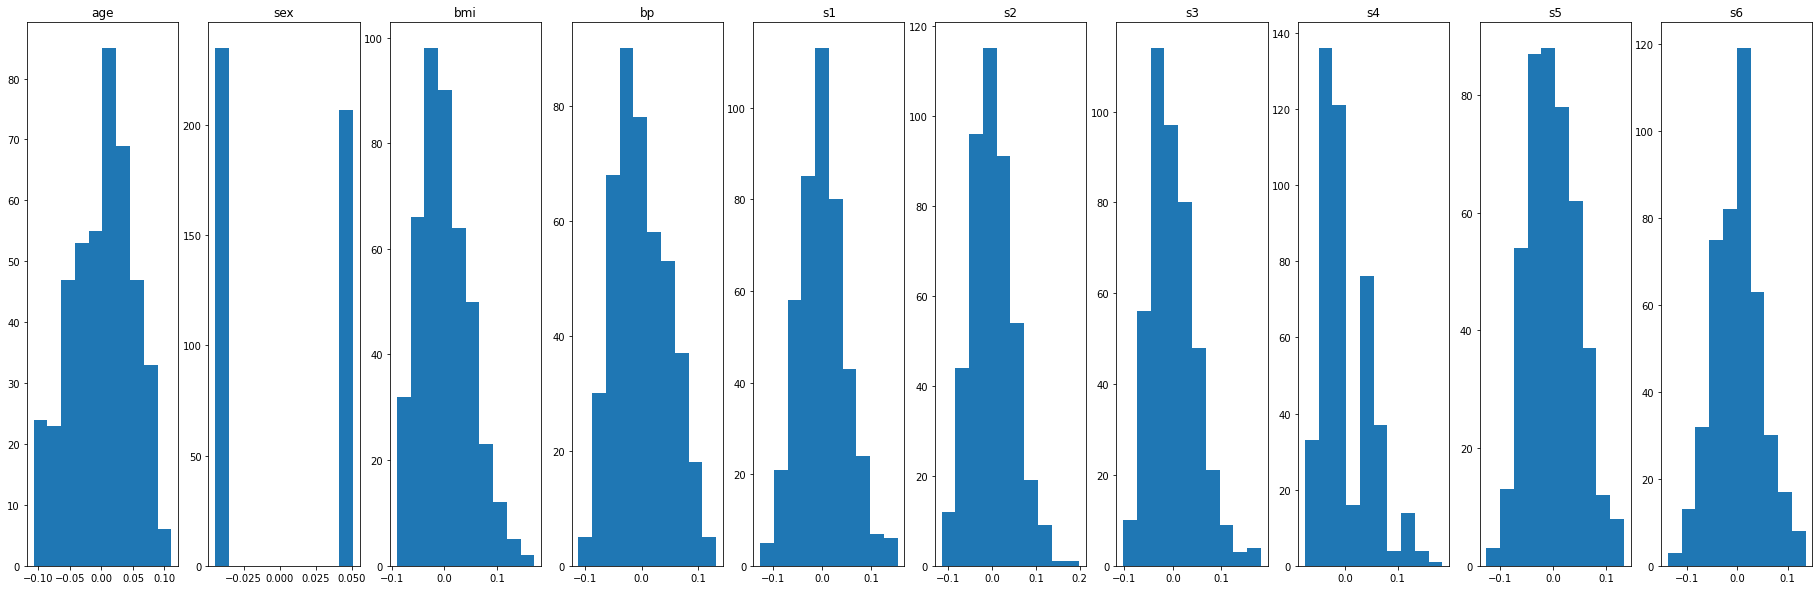

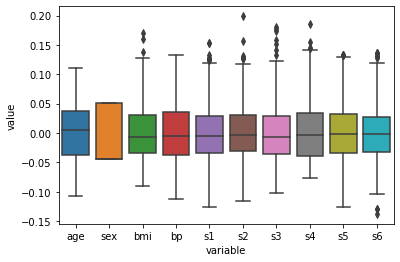

In [5]:
%matplotlib inline


# Plotting the features of the data
num_features = len(data.columns)
fig, axarr = plt.subplots(1, num_features, squeeze=False, figsize=(32, 10))
fig.set_facecolor('#ffffff')
i=0
for (cat, content) in data.items():
    axarr[0, i].hist(content)
    axarr[0, i].set_title(cat)
    i = i+1
plt.show()

# Box-plotting the data
bxplt = sns.boxplot(x="variable", y="value", data=pd.melt(data))
# data.boxplot()
bxplt.set_facecolor('#ffffff')

From the boxplot we can see that the dataset has several outliers. These might influence the
learning algorithm. Removing the outliers from the dataset might be tempting, but it will also make the model
less able to generalize on new data. Therefore I'll leave the outliers in, even though it might mean that my model
might be less accurate.

# KMeans
I then used the kMeans method to try to divide the dataset into two categories. Because the kMeans is unsupervised
there is no guarantee that it will divide the dataset into classes corresponding with the target.

I plotted the results in a confusion matrix

Accuracy on training set: 0.688


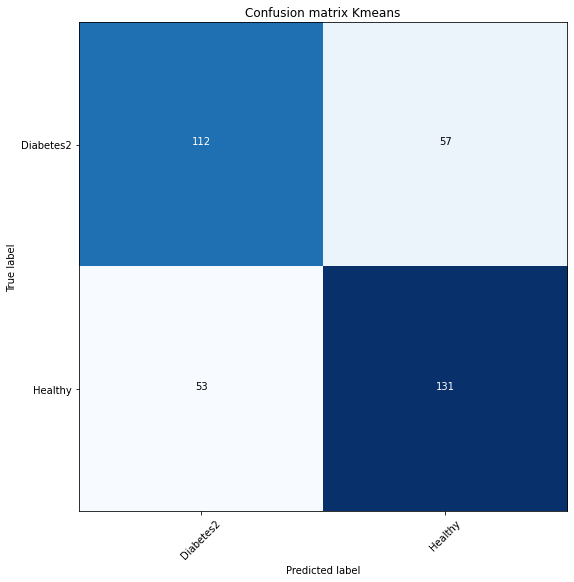

In [6]:
# trying to separate the groups by Kmeans

kmean = KMeans(n_clusters=2, random_state=42)

# data_train_no_labels = data_train.iloc[:,:-2] # taking away two columns from the dataset
features = ['age','sex','bmi','bp','s1','s2','s3','s4','s5','s6']
data_train_no_labels = data_train[features] # taking away two columns from the dataset
# print(data_train_no_labels.shape)
kmean_train_predict = kmean.fit_predict(data_train_no_labels)

df_kmean_train_predict = pd.DataFrame(data=kmean_train_predict)
df_kmean_train_predict.columns = ['classification']

# Adding the class label and predicted to the dataset.
df_train = pd.DataFrame(data=(data_train))
df_train['class'] = class_train
df_train['class_predict'] = kmean_train_predict

# kmean_test_predict = kmean.predict(data_test)
cm = confusion_matrix(df_train['class'],df_train['class_predict'])
plot_confusion_matrix(cm, ['Diabetes2', 'Healthy'], 'Kmeans', colorbar=False)
(tn, fp), (fn, tp) = cm
score = (tn+tp)/sum(sum(cm))
print("Accuracy on training set: {:.3f}".format(score))

The data can further be analyzed with the `seaborn.pariplot()` which plots each feature in relation to each other.

As the different plots show, there are much overlap between the classes. Some relations are clear though;
like the linearity between `s1` and `s2`. The `sex` does not seem to have any implications on the outcome.

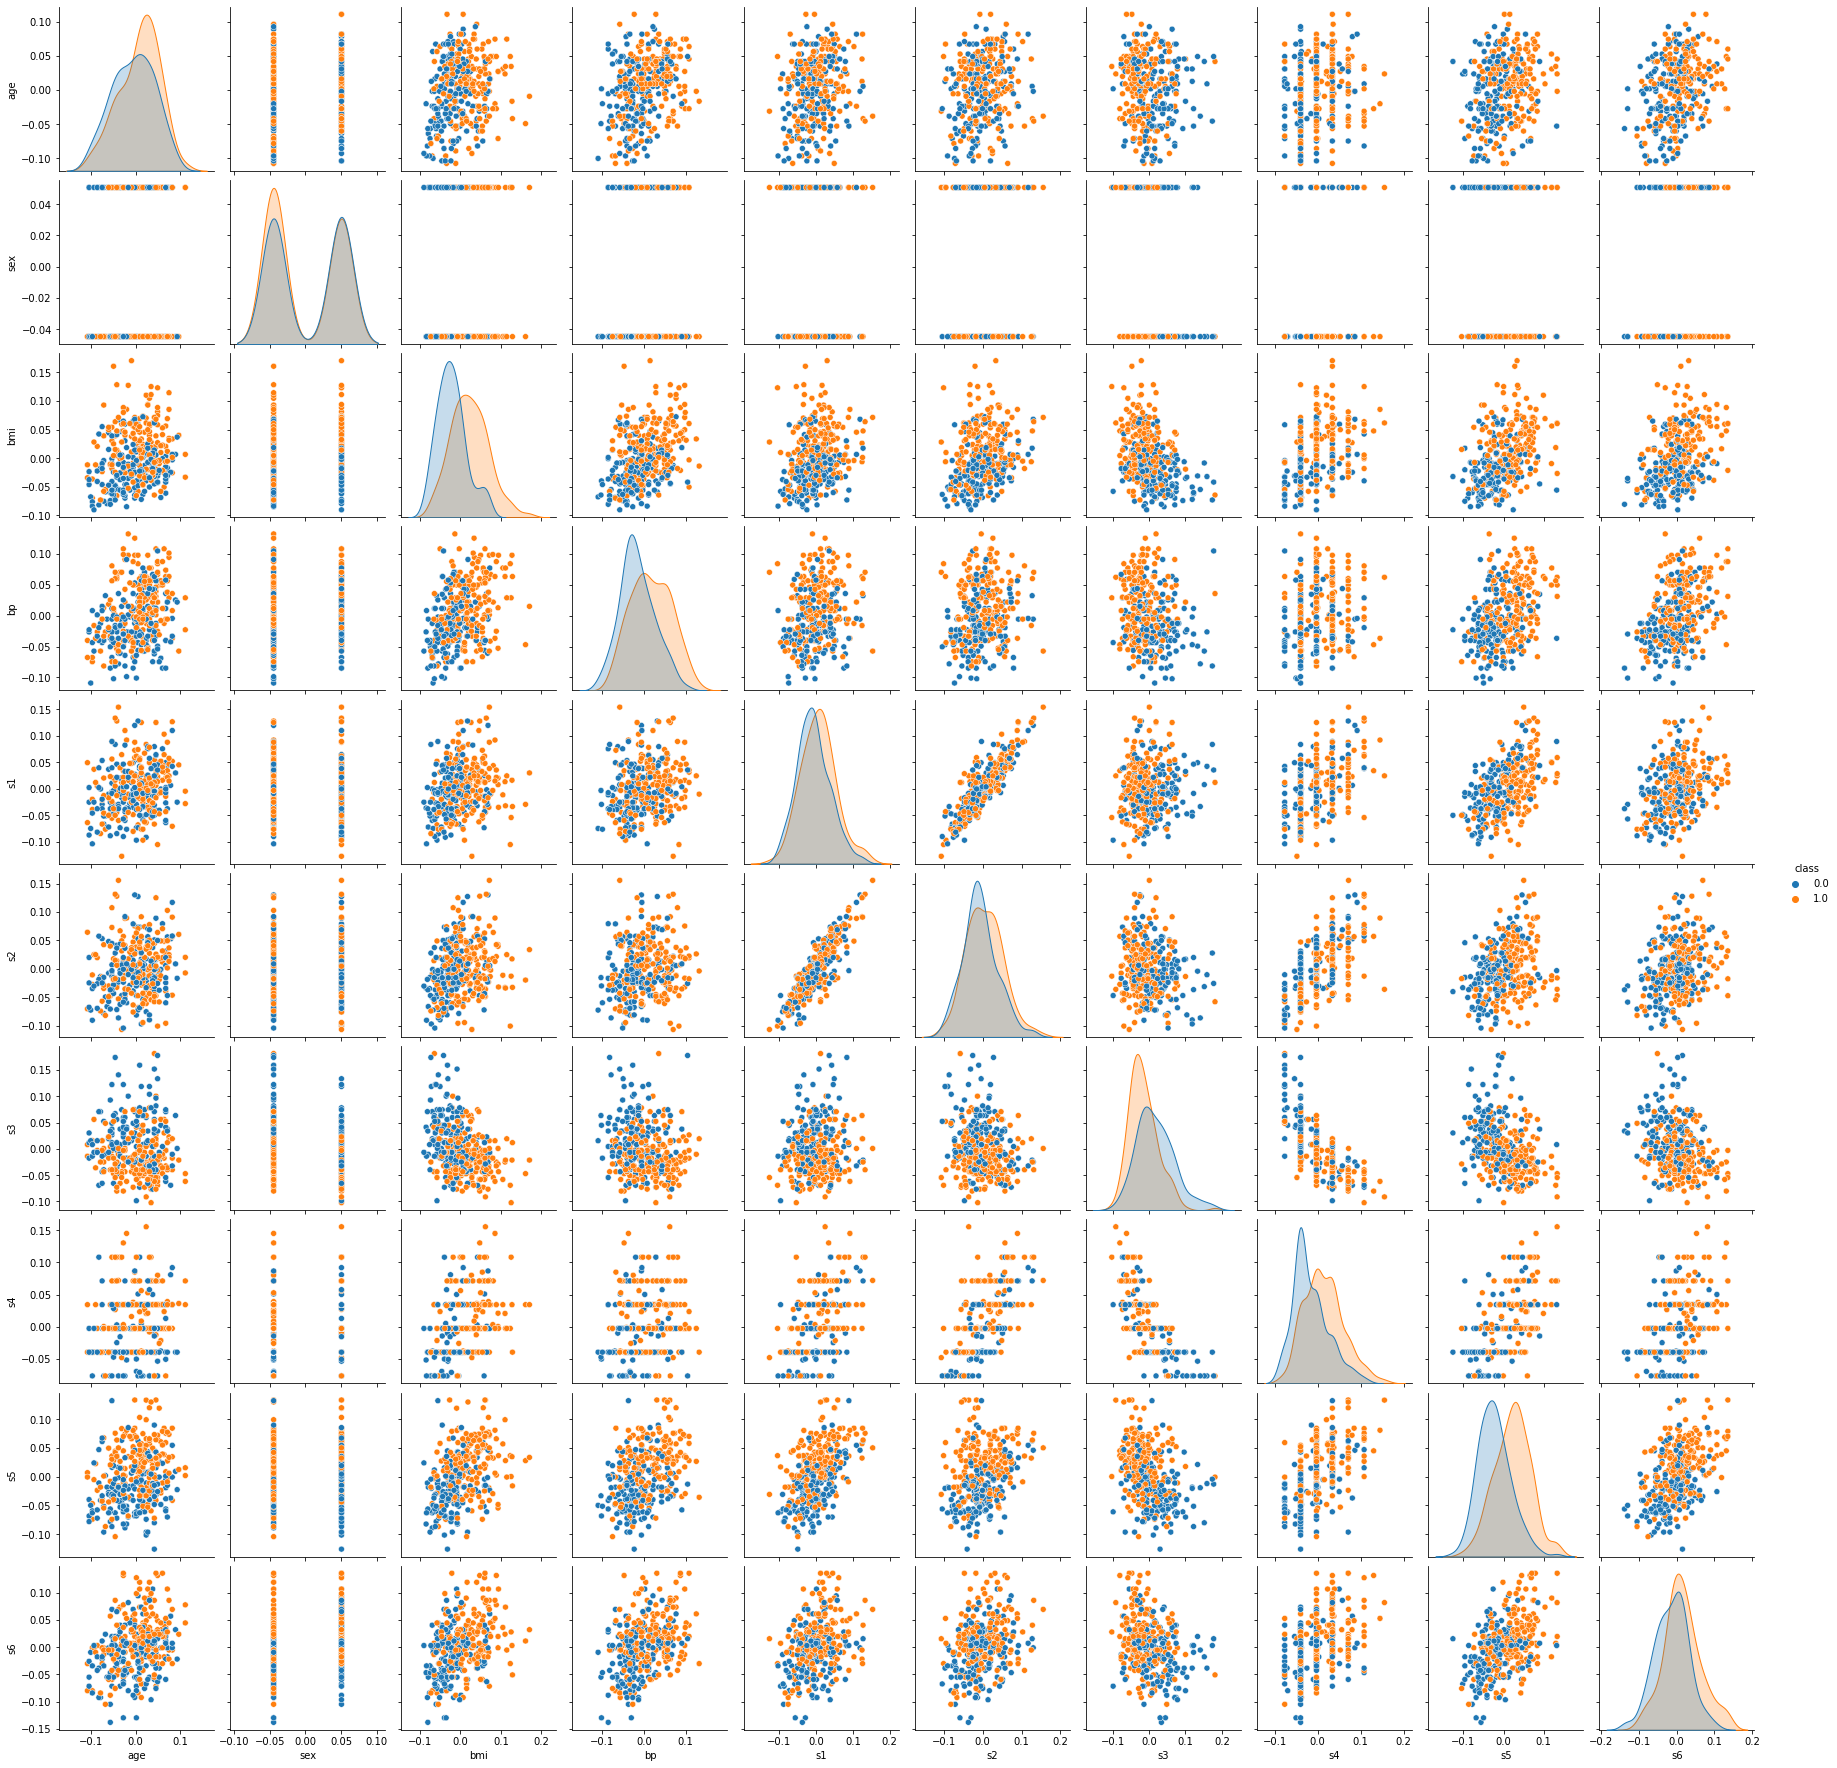

In [7]:
# Plotting the pair-plot of the dataset features
newFeatures = features.copy()
newFeatures.append('class')
grid = sns.pairplot(df_train[newFeatures], hue='class')

As this plot does not result in any clear distinction between data-points, I'll try to plot the data with the use
of PCA.

To plot this in 2d i choose two components for the PCA hyper-parameters.
This divided the data into four clusters, with a clear separation.
It would be possible to separate the classes based on this

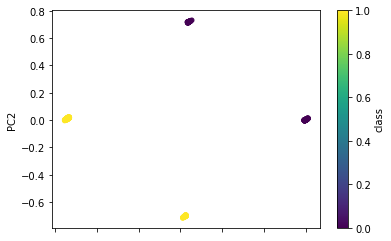

In [8]:
# PCA for visualization in 2d
pca = PCA(n_components=2)
data_train_reduced = pca.fit_transform(data_train)

df_PCA_reduced = pd.DataFrame(data_train_reduced)
df_PCA_reduced.columns = ['PC1', 'PC2']
df_PCA_reduced['class'] = kmean_train_predict

#Plotting the data
colormap = ['r','g']
df_PCA_reduced.plot.scatter(x='PC1', y='PC2', c='class', colormap='viridis')
plt.show()

## Multi level perceptron

I'll use a Multi level perceptron classifier to try the classification of the data. I used  the `MLPClassifier` from `sklearn`
for this.
That resulted in the following accuracy and confusion matrices

In [9]:
mlpClass = MLPClassifier(hidden_layer_sizes=(100,30,), max_iter=400)

mlpClass.fit(data_train_no_labels, class_train)

/home/steffen/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 30), max_iter=400)

Accuracy on training set: 0.765
Accuracy on test set: 0.798
precision score:  0.7947154471544715
recall score:  0.7974358974358975


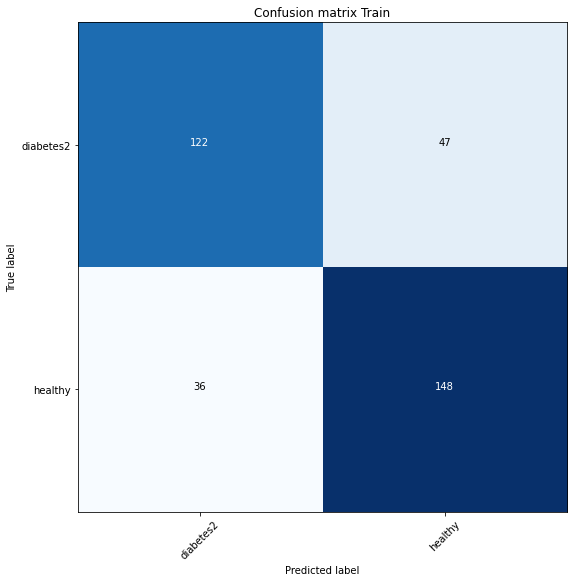

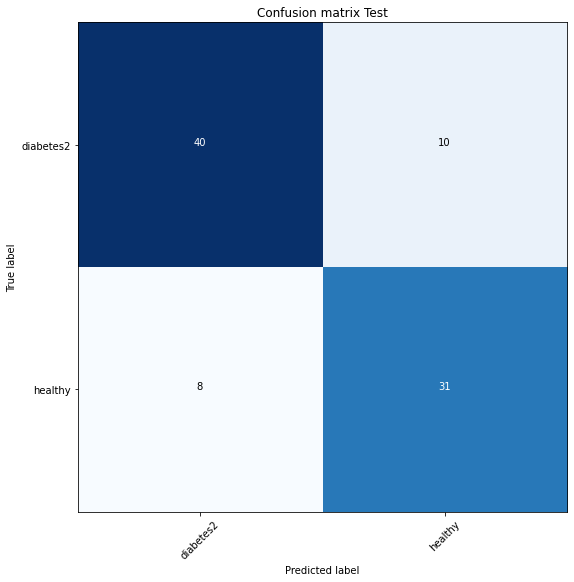

In [20]:
labels = ['diabetes2', 'healthy']
predicted_train = mlpClass.predict(data_train_no_labels)
predicted = mlpClass.predict(data_test)
fig_train = plot_confusion_matrix(confusion_matrix(y_true=class_train, y_pred=predicted_train), labels, 'Train', colorbar=False)
cm = confusion_matrix(y_true=class_test, y_pred=predicted)
fig_test = plot_confusion_matrix(cm, labels, 'Test', colorbar=False)
print("Accuracy on training set: {:.3f}".format(mlpClass.score(data_train_no_labels, class_train)))
print("Accuracy on test set: {:.3f}".format(mlpClass.score(data_test, class_test)))
print("Precision score: ", precision_score(y_true=class_test, y_pred=predicted, average='macro'))
print("Recall score: ", recall_score(y_true=class_test, y_pred=predicted, average='macro'))

## Select K Best
I also tried `SelectKBest` to classify the dataset. This resulted in the following plot.

Here there are some tendencies for separation, but no clear distinction between the points

In [11]:
# K best
skb = SelectKBest(chi2, k = 2)
scaled = MinMaxScaler(feature_range=(0,1)).fit_transform(data_train_no_labels)
kBest = skb.fit_transform(scaled, class_train)

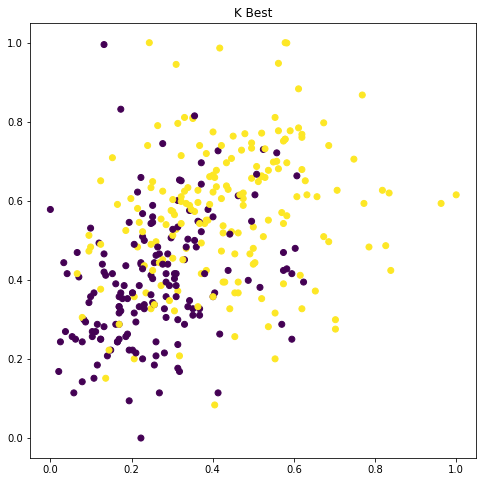

In [12]:
figureKbest = plot_k_best(kBest, class_train)

## Regression with Keras

I also tried building a regression model with and without regularization to predict the possible risk score.
The models were built with `tenserflow.keras`. 

In [13]:
# Building the model
regression_model = Sequential(layers=[
    InputLayer(input_shape=(10,)),
    Dense(units=40, activation='relu'),
    Dense(units=1)
])

regression_model.compile(optimizer='adam', loss='mean_squared_error')
regression_model.summary()

regression_model_w_regularization = Sequential(
    layers= [
        InputLayer(input_shape=(10,)),
        Dense(units=40, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(units=1)
    ])
regression_model_w_regularization.compile(optimizer='adam', loss='mean_squared_error')
regression_model_w_regularization.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                440       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 40)                440       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = regression_model.fit(
                     x=data_train_no_labels,
                     y=target_train,
                     verbose=0,
                     validation_data=(data_test, target_test),
                     epochs=250)
history_regulized = regression_model_w_regularization.fit(
                     x=data_train_no_labels,
                     y=target_train,
                     verbose=0,
                     validation_data=(data_test, target_test),
                     epochs=250)

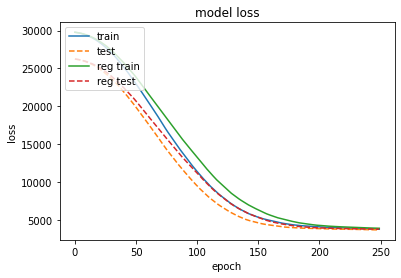

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], ls='--')
plt.plot(history_regulized.history['loss'])
plt.plot(history_regulized.history['val_loss'], ls='--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test','reg train', 'reg test'], loc='upper left')
plt.show()

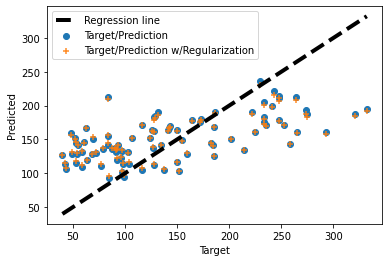

In [16]:
predicted = regression_model.predict(data_test)
predicted_reg = regression_model_w_regularization.predict(data_test)
fig, ax = plt.subplots()
ax.scatter(target_test, predicted, label='Target/Prediction')
ax.scatter(target_test, predicted_reg, label='Target/Prediction w/Regularization', marker='+', alpha=.9)
ax.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=4, label='Regression line')
ax.set_xlabel('Target')
ax.set_ylabel('Predicted')
ax.legend()
plt.show()